In [1]:
# Parsing ascii files from the eyelink into eye position and data table files
# Clara Kuper, September 2020

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import ipywidgets as widgets
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
# get the files, this will be set up in a bigger loop later
# open files and read them 
# todo:
# write out every new presentation of a target
# write out all saccade onsets
# find the point when both fixated, set this as trial_start

# next: plot the location of the stimuli
# next: compare timing from eyelink and other data.

f = open('../edf/ck44_NS.asc','r')
l = f.readlines()
read = False
time_start = 4
time_end = 11
line = 0

# read the file till the first block starts (discarding all information before)
while not read:
    if l[line].find('EXPERIMENT STARTED')>=0:
        start_id = line
        read = True
    line += 1

# set up the tables where we will save the data.
# there will be two of them, one for the continuous eye position, one for the responses and message timing
raw_list = [] # for eye position data
events = [] # for time stamps of events
tr_nr = 0 # set the trial number to 0
block_nr = 0 # set the block number to 0
mov_type = 'unknown' # unknown, saccade, blink, fixation
tar_y = None
in_trial = False # we only want the eye position when the trial has started (after trial_start)

for line in l[start_id:]:
    
    # additional information for the table
    append_message = [block_nr, tr_nr, mov_type, tar_y]
    
    if line[0:3].isnumeric(): # either the line starts with a number (time stamp), or with a string (message or detected movement)
            position_data = np.hstack((line.split(),append_message))
            #print(position_data)
            raw_list.append(position_data)
        
    else: 
            
        if line.find('BLOCK_START')>=0:
            block = line.find('BLOCK_START')
            block_nr = int(line[block+len('BLOCK_START')+2:])
            
        if line.find('TRIAL_SYNCTIME')>=0:
            sync = line.find('TRIAL SYNCTIME')
            sync_t = int(line[time_start:time_end])
        
        if line.find('TRIAL_START')>= 0:
            start = line.find('TRIAL_START')
            start_t = line[time_start:time_end]
            tr_nr = int(line[start+len('TRIAL_START')+2:])
            
            # set all values to read out to none
            stim_on = None
            eyes_fix = None
            kb_down = None
            att_moved = None
            hand_moved = None
            att_dis = None
            hand_stopped = None
            att_goal = None
            feedback_shown = None
            response_cat = None
            tar_y = None
            
            in_trial = True
            
        if line.find('EXPERIMENT_END')>=0:
            break
    

        if in_trial:
            
            if line[0:3]=='MSG':
                
                # get time write to table
                if line.find('STIM_ON_SCREEN')>=0:
                    stim_on = int(line[time_start:time_end])
                    
                if line.find('EYES_FIXATED')>=0:
                    eyes_fix = int(line[time_start:time_end])
                    
                if line.find('KEYBOARD_DOWN')>=0:
                    kb_down = int(line[time_start:time_end])
                
                if line.find('BOTH_FIX')>=0:
                    fix_t = int(line[time_start:time_end])
                    
                if line.find('ATTACKER_MOVED')>=0:
                    att_moved = int(line[time_start:time_end])
                
                if line.find('NEW_TARGET')>=0:
                    line_parsed = line.split('y: ')
                    tar_y = int(line_parsed[1])
                    
                if line.find('START_HAND_MOVEMENT')>=0:
                    hand_moved = int(line[time_start:time_end])
                    
                if line.find('ATTACKER_DISAPPEARED')>=0:
                    att_dis = int(line[time_start:time_end])
                    
                if line.find('END_HAND_MOVEMENT')>=0:
                    hand_stopped = int(line[time_start:time_end])
                    
                if line.find('ATTACKER_REACHED_GOAL')>=0:
                    att_goal = int(line[time_start:time_end])
                    
                if line.find('FEEDBACK_PRESENTED')>=0:
                    feedback_shown = int(line[time_start:time_end])
                    
                if line.find('RESPONSE_TRIAL')>=0:
                    line_parsed = line.split(', ')
                    response_cat = line_parsed[-1]
                    response_cat = response_cat[0:-1]
        
                if line.find('TRIAL_END')>=0:
            
                    end_t = line[time_start:time_end]
                    trial_events = [block_nr, tr_nr, sync_t, fix_t, stim_on, eyes_fix, kb_down, att_moved, 
                                    hand_moved, att_dis, hand_stopped, att_goal, feedback_shown, response_cat]
                    events.append(trial_events)
                    in_trial = False
                
            else:
                # define eye movement types
                if line.find('SSACC')>=0:
                    mov_type = 'saccade'
            
                if line.find('ESACC')>=0:
                    mov_type = 'unknown'
            
                if line.find('SFIX')>=0:
                    mov_type = 'fixation'
            
                if line.find('EFIX')>=0:
                    mov_type = 'unknown' 
            
                if line.find('SBLINK')>=0:
                    mov_type = 'blink'

                if line.find('EBLINK')>=0:
                    mov_type = 'unknown'


In [3]:
event_data = pd.DataFrame(events, columns = ['block', 'trial', 'sync', 'fix', 'stim_on', 'eyes_fix', 'kb_down',
                                            'att_moved', 'hand_moved', 'att_dis', 'hand_stopped', 'att_goal',
                                            'feedback_shown', 'response_cat'])
event_data

,block,trial,sync,fix,stim_on,eyes_fix,kb_down,att_moved,hand_moved,att_dis,hand_stopped,att_goal,feedback_shown,response_cat
0,1,1,4983477,4984927,4983486,4983903,4984920,4985492,4985828.0,4985978,4986104.0,4986294,4986296,FALSE ALARM
1,1,2,4986590,4987102,4986594,4986803,4987094,4987666,4988019.0,4988153,4988269.0,4988461,4988462,HIT
2,1,3,4988753,4989053,4988761,4988961,4989045,4989616,4990161.0,4990103,4990386.0,4990411,4992416,FIXATION_BREAK
3,1,4,4992740,4993178,4992745,4993053,4993169,4993741,NaN,4994228,NaN,4994536,4997841,FIXATION_BREAK
4,1,5,4998131,4998536,4998136,4998336,4998528,4999099,NaN,4999586,NaN,4999894,4999897,CORRECT REJECTION
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,2,83,5455501,5456047,5455506,5456039,5456014,5456610,5457022.0,5457097,5457289.0,5457406,5457406,HIT
198,2,84,5457702,5458006,5457706,5457939,5457997,5458569,NaN,5459056,NaN,5459364,5459364,CORRECT REJECTION
199,2,85,5459659,5460830,5459664,5460823,5459706,5461393,NaN,5461874,NaN,5462189,5462189,MISS
200,2,86,5462481,5464164,5462489,5464156,5462489,5464727,5465131.0,5465214,5465439.0,5465523,5465523,FALSE ALARM


In [4]:
eye_position = pd.DataFrame(raw_list, columns = ['time', 'x_pos', 'y_pos', 'pupil', 'right','block', 'trial', 'move_type', 'tar_y'])
eye_position

,time,x_pos,y_pos,pupil,right,block,trial,move_type,tar_y
0,4983429,1356.0,1338.5,964.0,...,1,0,unknown,None
1,4983430,1356.2,1338.2,960.0,...,1,0,unknown,None
2,4983431,1356.4,1338.3,960.0,...,1,0,unknown,None
3,4983432,1356.3,1338.2,961.0,...,1,0,unknown,None
4,4983433,1356.2,1338.2,962.0,...,1,0,unknown,None
...,...,...,...,...,...,...,...,...,...
396676,5467511,1265.6,607.8,1319.0,...,2,87,fixation,538
396677,5467512,1265.6,607.8,1314.0,...,2,87,fixation,538
396678,5467513,1265.0,607.7,1315.0,...,2,87,fixation,538
396679,5467514,1264.4,607.5,1315.0,...,2,87,fixation,538


In [5]:
no_x_pos_available = np.where(eye_position['x_pos'] == '.')
no_y_pos_available = np.where(eye_position['y_pos'] == '.')
no_pupil_available = np.where(eye_position['pupil'] == '.')

eye_position['x_pos'].iloc[no_x_pos_available] = '0'
eye_position['y_pos'].iloc[no_y_pos_available] = '0'
eye_position['pupil'].iloc[no_pupil_available] = '0'

eye_position['time'] = pd.to_numeric(eye_position['time'])
eye_position['x_pos'] = pd.to_numeric(eye_position['x_pos'])
eye_position['y_pos'] = pd.to_numeric(eye_position['y_pos'])
eye_position['pupil'] = pd.to_numeric(eye_position['y_pos'])
eye_position['trial'] = pd.to_numeric(eye_position['trial'])
eye_position['block'] = pd.to_numeric(eye_position['block'])

In [6]:
# visualize eye position per trial
def plot_func(trial, block):
    #get index to trial
    data_id_trial = np.where(eye_position['trial']== trial)[0]
    data_id_block = np.where(eye_position['block']==block)[0]
    trial_data = eye_position.iloc[np.intersect1d(data_id_trial, data_id_block)]
        
    #get index to block
    event_id_trial = np.where(event_data['trial']== trial)[0]
    event_id_block = np.where(event_data['block']==block)[0]
    trial_events = event_data.iloc[np.intersect1d(event_id_trial, event_id_block)]
    trial_data['time'] = trial_data['time'].values - trial_events['fix'].values
    fig, axs = plt.subplots(1,1, figsize = (10,7))
    axs.scatter(trial_data['time'], trial_data['y_pos'], label = 'y gaze')
    axs.scatter(trial_data['time'], trial_data['x_pos'], label = 'x gaze')
    axs.scatter(trial_data['time'], trial_data['tar_y'], label = 'y target')
    axs.axhline(y = 1656, xmin = 0, xmax = 2000, label = 'x target')
    
    axs.set_xlim([0,2000])
    axs.set_ylim([0,2000])
    axs.axvline(x=trial_events['att_moved'].values-trial_events['fix'].values,ymin = 0, ymax = 2000, label = 'go', color = 'r')
    axs.axvline(x=trial_events['hand_moved'].values-trial_events['fix'].values,ymin = 0, ymax = 2000, label = 'moveOn', color = 'c')
    axs.axvline(x=trial_events['hand_stopped'].values-trial_events['fix'].values,ymin = 0, ymax = 2000, label = 'moveOff', color = 'm' )
    axs.axvline(x=trial_events['att_goal'].values-trial_events['fix'].values,ymin = 0, ymax = 2000, label = 'attGoal', color = 'y')
    
    axs.legend(loc = 2)


trial_slider = widgets.IntSlider(min=1,
    max=tr_nr,                          
    step=1,
    description='Trial No:',
    value=1,
    continuous_update = False) #difference units drift

block_slider = widgets.IntSlider(min=1,
    max=block_nr,                          
    step=1,
    description='Block No:',
    value=1,
    continuous_update = False) #difference units drift

widgets.interact(plot_func, trial = trial_slider,block = block_slider)

    

interactive(children=(IntSlider(value=1, continuous_update=False, description='Trial No:', max=87, min=1), Int…

<function __main__.plot_func(trial, block)>

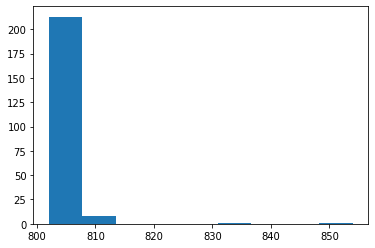

In [7]:
plt.hist(event_data['att_goal']-event_data['att_moved'], bins =9);